### Reading in data

The data are CSV files. In Spark, these can be read using textFile and splitting rows on commas.

In [1]:
from pyspark.sql import SparkSession, SQLContext, Row
gcs_bucket='sincere-pen-389114'
spark = SparkSession.builder.appName("kdd").getOrCreate()
sc = spark.sparkContext
data_file = "gs://"+gcs_bucket+"//kddcup.data_10_percent.gz"
raw_rdd = sc.textFile(data_file).cache()
raw_rdd.take(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/26 04:49:31 INFO SparkEnv: Registering MapOutputTracker
23/07/26 04:49:31 INFO SparkEnv: Registering BlockManagerMaster
23/07/26 04:49:31 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/07/26 04:49:32 INFO SparkEnv: Registering OutputCommitCoordinator
23/07/26 04:49:40 WARN GhfsStorageStatistics: Detected potential high latency for operation op_get_file_status. latencyMs=441; previousMaxLatencyMs=0; operationCount=1; context=gs://dataproc-temp-us-central1-387021963560-qcsdihcz/45346b86-8b3d-4e0d-8fa1-b8c6db524c56/spark-job-history
23/07/26 04:49:41 WARN GhfsStorageStatistics: Detected potential high latency for operation op_mkdirs. latencyMs=262; previousMaxLatencyMs=0; operationCount=1; context=gs://dataproc-temp-us-central1-387021963560-qcsdihcz/45346b86-8b3d-4e0d-8fa1-b8c6db524c56/spark-job-history
23/07/26 04:49:41 WARN GhfsStorageStatist

['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.']

In [2]:
csv_rdd = raw_rdd.map(lambda row: row.split(","))
parsed_rdd = csv_rdd.map(lambda r: Row(
    duration=int(r[0]), 
    protocol_type=r[1],
    service=r[2],
    flag=r[3],
    src_bytes=int(r[4]),
    dst_bytes=int(r[5]),
    wrong_fragment=int(r[7]),
    urgent=int(r[8]),
    hot=int(r[9]),
    num_failed_logins=int(r[10]),
    num_compromised=int(r[12]),
    su_attempted=r[14],
    num_root=int(r[15]),
    num_file_creations=int(r[16]),
    label=r[-1]
    )
)
parsed_rdd.take(5)

[Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=181, dst_bytes=5450, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=239, dst_bytes=486, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=235, dst_bytes=1337, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=219, dst_bytes=1337, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp',

### Spark analysis

One way to analyze data in Spark is to call methods on a dataframe.

In [3]:
sqlContext = SQLContext(sc)
df = sqlContext.createDataFrame(parsed_rdd)
connections_by_protocol = df.groupBy('protocol_type').count().orderBy('count', ascending=False)
connections_by_protocol.show()

/usr/lib/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-------------+------+
|protocol_type| count|
+-------------+------+
|         icmp|283602|
|          tcp|190065|
|          udp| 20354|
+-------------+------+



Another way is to use Spark SQL

In [4]:
df.registerTempTable("connections")
attack_stats = sqlContext.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as total_freq,
                             ROUND(AVG(src_bytes), 2) as mean_src_bytes,
                             ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
                             ROUND(AVG(duration), 2) as mean_duration,
                             SUM(num_failed_logins) as total_failed_logins,
                             SUM(num_compromised) as total_compromised,
                             SUM(num_file_creations) as total_file_creations,
                             SUM(su_attempted) as total_root_attempts,
                             SUM(num_root) as total_root_acceses
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
attack_stats.show()

/usr/lib/spark/python/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+-------------+---------+----------+--------------+--------------+-------------+-------------------+-----------------+--------------------+-------------------+------------------+
|protocol_type|    state|total_freq|mean_src_bytes|mean_dst_bytes|mean_duration|total_failed_logins|total_compromised|total_file_creations|total_root_attempts|total_root_acceses|
+-------------+---------+----------+--------------+--------------+-------------+-------------------+-----------------+--------------------+-------------------+------------------+
|         icmp|   attack|    282314|        932.14|           0.0|          0.0|                  0|                0|                   0|                0.0|                 0|
|          tcp|   attack|    113252|       9880.38|        881.41|        23.19|                 57|             2269|                  76|                1.0|               152|
|          tcp|no attack|     76813|       1439.31|       4263.97|        11.08|                 18|     

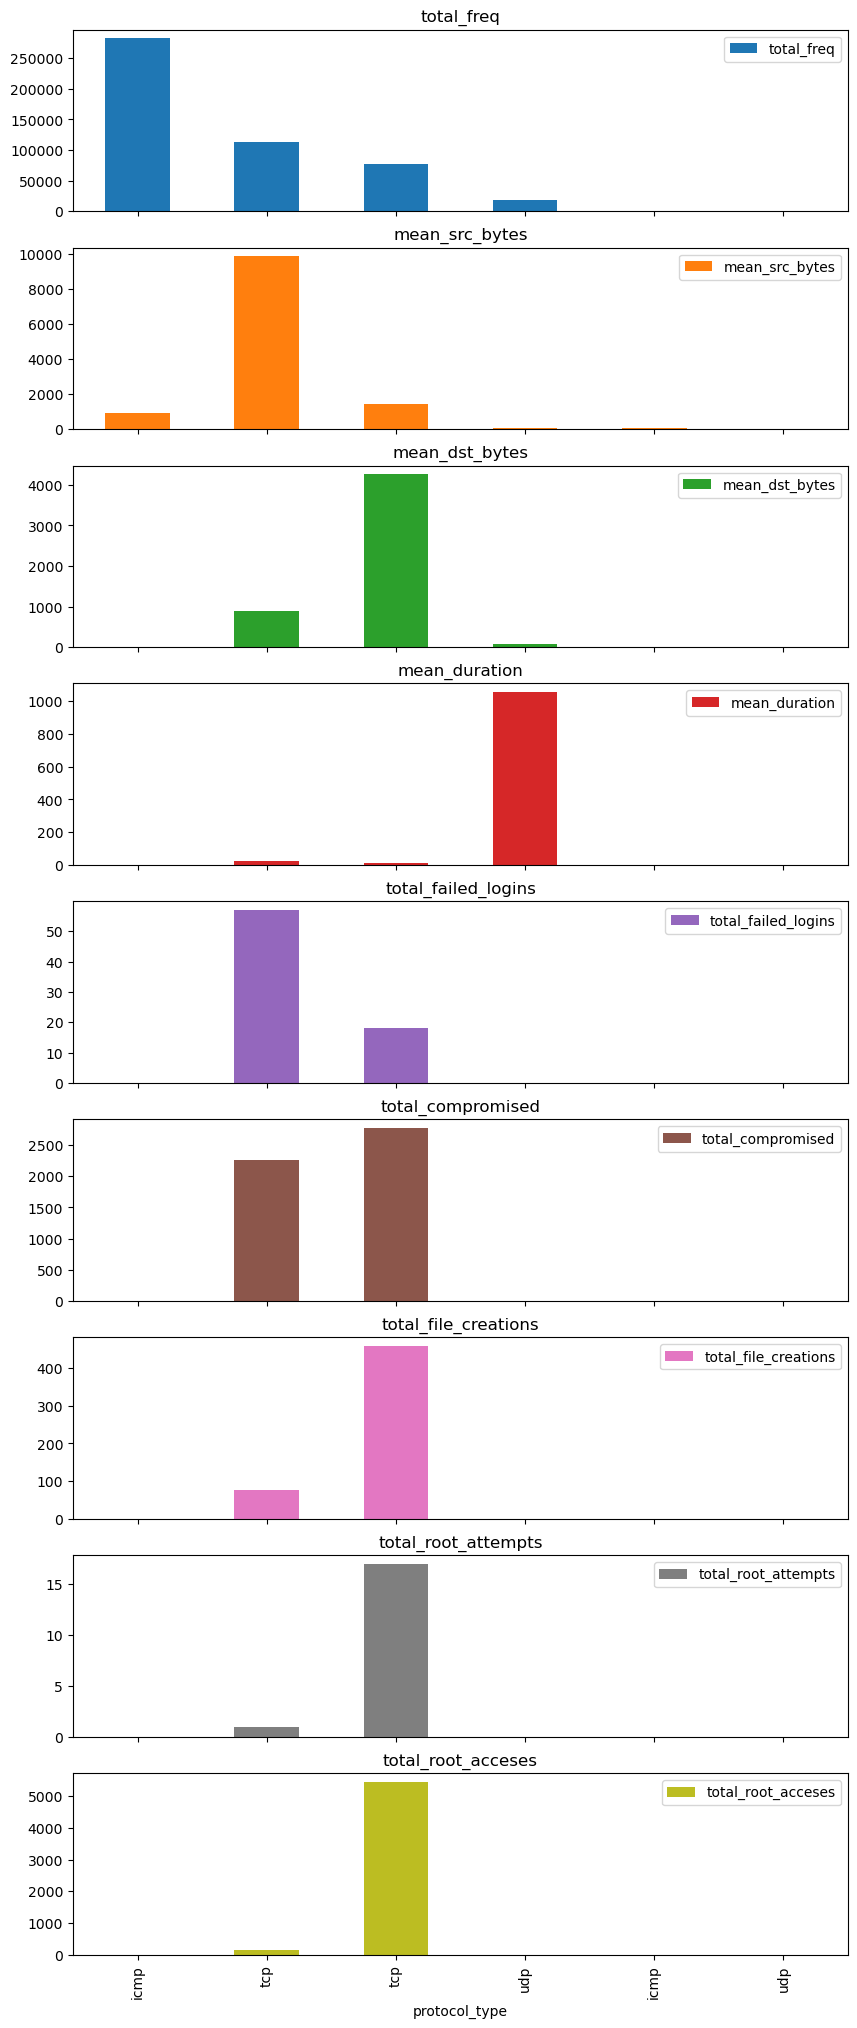

In [5]:
%matplotlib inline
ax = attack_stats.toPandas().plot.bar(x='protocol_type', subplots=True, figsize=(10,25))

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.